## Graph Neural Networks in Python
An introduction and step-by-step implementation

We start by creating an empty directed graph H 

简单测试怎么构造自己的数据，以及可视化

In [163]:
import networkx as nx
# import matplotlib.pyplot as plt
H = nx.DiGraph()

In [164]:
H.add_nodes_from([
    (0, {"color": "gray", "size": 450}),
    (1, {"color": "yellow", "size": 700}),
    (2, {"color": "red", "size": 250}),
    (3, {"color": "pink", "size": 500})
])

In [165]:
for node in H.nodes(data=True):
    print(node)

(0, {'color': 'gray', 'size': 450})
(1, {'color': 'yellow', 'size': 700})
(2, {'color': 'red', 'size': 250})
(3, {'color': 'pink', 'size': 500})


In [166]:
H.add_edges_from([
    (0, 1),
    (1, 2),
    (2, 0),
    (2, 3),
    (3, 2)
])
print(H.edges())

[(0, 1), (1, 2), (2, 0), (2, 3), (3, 2)]


In [167]:
def print_graph_info(graph):
    print("Directed graph:", graph.is_directed())
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())

print_graph_info(H)

Directed graph: True
Number of nodes: 4
Number of edges: 5


In [168]:
node_colors = nx.get_node_attributes(H, "color")
print(node_colors)

{0: 'gray', 1: 'yellow', 2: 'red', 3: 'pink'}


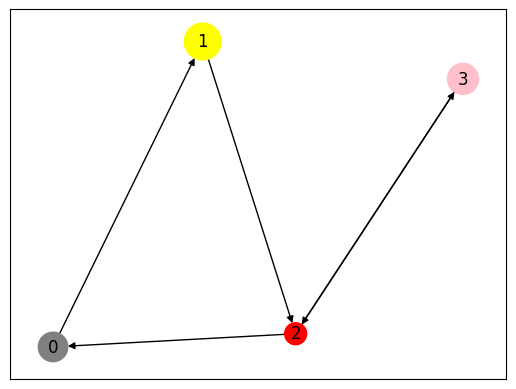

In [169]:
# plt.figure(figsize=(10, 6))
node_colors = nx.get_node_attributes(H, "color").values()
# print(node_colors)
colors = list(node_colors)
# print(colors)

node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

nx.draw_networkx(H, with_labels=True, node_color=colors, node_size=sizes)

In [170]:
G = H.to_undirected()
print_graph_info(G)

Directed graph: False
Number of nodes: 4
Number of edges: 4


In [171]:
print(G.edges())

[(0, 1), (0, 2), (1, 2), (2, 3)]


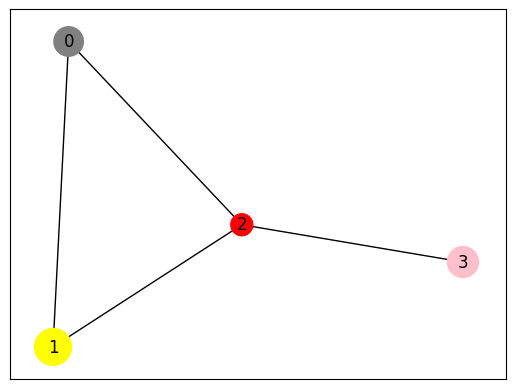

In [172]:
nx.draw_networkx(G, with_labels=True, node_color=colors, node_size=sizes)

## 以KarateClub进行动态模拟

In [173]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Nodes:", dataset[0].num_nodes)
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)
print("# Edges:", dataset[0].num_edges)

Dataset: KarateClub()
# Graphs: 1
# Nodes: 34
# Features: 34
# Classes: 4
# Edges: 156


In [174]:
data = dataset[0]

print(data)
print(f'NUmber of training nodes: {data.train_mask.sum()}')
print("Is directed:", data.is_directed())

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
NUmber of training nodes: 4
Is directed: False


In [175]:
# view true lables
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [176]:
# Count each class of number
import collections
counter = collections.Counter(data.y.numpy())
print(counter)

Counter({0: 13, 1: 12, 3: 5, 2: 4})


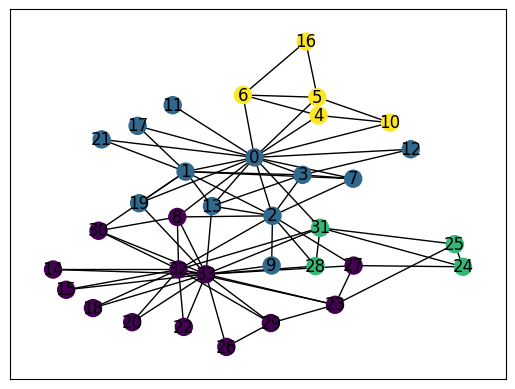

In [177]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
my_pos = nx.kamada_kawai_layout(G) # Fixed-Position
nx.draw_networkx(G, node_color=data.y, node_size=150, pos=my_pos)

In [178]:
import numpy as np
train_mask_numpy = data.train_mask.numpy()
training_node_index = np.where(train_mask_numpy==True)
print("The index of training samples: ", training_node_index)
print("Class of training samples: ", data.y[training_node_index])

The index of training samples:  (array([ 0,  4,  8, 24], dtype=int64),)
Class of training samples:  tensor([1, 3, 0, 2])


In [179]:
# #### 训练集一类一种颜色，其余一种颜色，进行绘图
import torch
my_color = torch.zeros_like(data.y) + 5
# my_color = torch.zeros_like(data.y)
my_color[0] = data.y[0]
my_color[4] = data.y[4]
my_color[8] = data.y[8]
my_color[24] = data.y[24]
print("Default color: ", data.y)
print("My color: ", my_color)

Default color:  tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
My color:  tensor([1, 5, 5, 5, 3, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        2, 5, 5, 5, 5, 5, 5, 5, 5, 5])


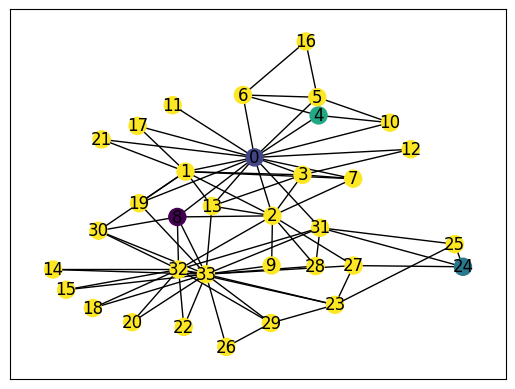

In [180]:
nx.draw_networkx(G, node_color=my_color, node_size=150, pos=my_pos)

### 修改后的GCN

In [181]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        return out, h


In [182]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [183]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [184]:
def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

In [185]:
epochs = range(1, 301)
losses = []
embeddings = []

for epoch in epochs:
    loss, h = train(data)
    losses.append(loss)
    embeddings.append(h)
    print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.3996
Epoch: 2	Loss: 1.3749
Epoch: 3	Loss: 1.3545
Epoch: 4	Loss: 1.3380
Epoch: 5	Loss: 1.3248
Epoch: 6	Loss: 1.3137
Epoch: 7	Loss: 1.3034
Epoch: 8	Loss: 1.2929
Epoch: 9	Loss: 1.2814
Epoch: 10	Loss: 1.2689
Epoch: 11	Loss: 1.2553
Epoch: 12	Loss: 1.2410
Epoch: 13	Loss: 1.2264
Epoch: 14	Loss: 1.2117
Epoch: 15	Loss: 1.1971
Epoch: 16	Loss: 1.1827
Epoch: 17	Loss: 1.1682
Epoch: 18	Loss: 1.1534
Epoch: 19	Loss: 1.1382
Epoch: 20	Loss: 1.1224
Epoch: 21	Loss: 1.1060
Epoch: 22	Loss: 1.0895
Epoch: 23	Loss: 1.0730
Epoch: 24	Loss: 1.0569
Epoch: 25	Loss: 1.0412
Epoch: 26	Loss: 1.0259
Epoch: 27	Loss: 1.0108
Epoch: 28	Loss: 0.9960
Epoch: 29	Loss: 0.9816
Epoch: 30	Loss: 0.9677
Epoch: 31	Loss: 0.9545
Epoch: 32	Loss: 0.9420
Epoch: 33	Loss: 0.9302
Epoch: 34	Loss: 0.9189
Epoch: 35	Loss: 0.9080
Epoch: 36	Loss: 0.8976
Epoch: 37	Loss: 0.8876
Epoch: 38	Loss: 0.8781
Epoch: 39	Loss: 0.8690
Epoch: 40	Loss: 0.8601
Epoch: 41	Loss: 0.8515
Epoch: 42	Loss: 0.8430
Epoch: 43	Loss: 0.8347
Epoch: 44	Loss: 0.82

In [186]:
print(loss)
print(embeddings)

tensor(0.0381, grad_fn=<NllLossBackward0>)
[tensor([[ 0.1812,  0.2238],
        [ 0.2396,  0.1765],
        [ 0.1503,  0.0841],
        [ 0.1739,  0.1367],
        [ 0.0496,  0.1503],
        [ 0.0728,  0.1715],
        [ 0.0748,  0.1743],
        [ 0.1636,  0.1165],
        [ 0.0774,  0.0232],
        [ 0.0483,  0.0035],
        [ 0.0596,  0.1508],
        [-0.0102,  0.0400],
        [ 0.0886,  0.0988],
        [ 0.1485,  0.0941],
        [-0.0091, -0.0518],
        [ 0.0083, -0.0493],
        [ 0.0562,  0.1433],
        [ 0.1652,  0.1332],
        [-0.0204, -0.0538],
        [ 0.1282,  0.0816],
        [-0.0115, -0.0551],
        [ 0.1386,  0.1174],
        [-0.0153, -0.0621],
        [-0.0043, -0.0532],
        [-0.0547, -0.0154],
        [-0.0654, -0.0222],
        [ 0.0184, -0.0467],
        [ 0.0068, -0.0254],
        [ 0.0021,  0.0042],
        [ 0.0107, -0.0634],
        [ 0.0894,  0.0189],
        [-0.0266, -0.0016],
        [-0.0104, -0.0740],
        [ 0.0268, -0.0526]], gra

#### animation

In [187]:
import matplotlib.animation as animation

def animate(i):
    ax.clear()
    h = embeddings[i]
    h = embeddings[i]
    h = h.detach().numpy()
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

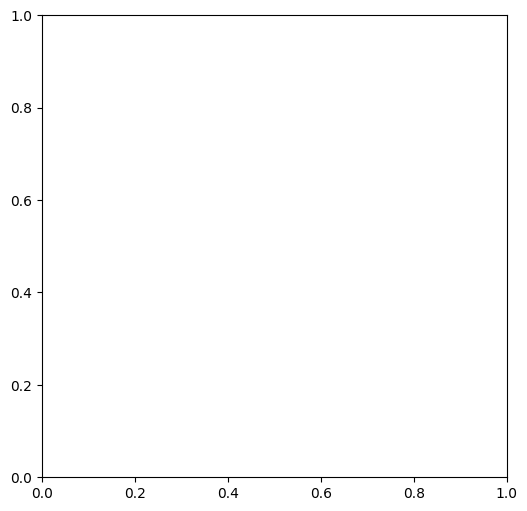

In [188]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
# myadd
my_epochs = range(0, 300)
# anim = animation.FuncAnimation(fig, animate, frames=epochs)
anim = animation.FuncAnimation(fig, animate, frames=my_epochs)
plt.show()

gif_writer = animation.PillowWriter(fps=20)
anim.save('embeddings.gif', writer=gif_writer)

## MyGCN
2023-02-11 by Chen Longlong

In [189]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch
import os

torch.manual_seed(42)

class MyGCN(nn.Module):
    def __init__(self, input_num_features, hidden_num_features, num_classes, dropout):
        super(MyGCN, self).__init__()
        torch.manual_seed(2021317110038)
        self.conv1 = GCNConv(input_num_features, hidden_num_features)
        self.conv2 = GCNConv(hidden_num_features, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, self.dropout, training=self.training)
        h = self.conv2(h, edge_index)
        out = F.log_softmax(h, dim=1)
        return out, h

        

In [190]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [191]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [192]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [193]:
input_num_features, num_classes, edge_index = dataset.num_features, dataset.num_classes, data.edge_index
hidden_num_features = 16
dropout = 0.5
model = MyGCN(input_num_features=input_num_features, 
              hidden_num_features=hidden_num_features, 
              num_classes=num_classes,
              dropout=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)

MyGCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [194]:
def train(data, epoch):
    model.train()
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss_train = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    acc_train = accuracy(out[data.train_mask], data.y[data.train_mask])
    loss_train.backward()
    optimizer.step()

    # Validation
    model.eval()
    val_out, temp = model(data.x, data.edge_index)
    loss_val = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
    acc_val = accuracy(val_out[data.val_mask], data.y[data.val_mask])

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()))

    return loss_train, acc_train, loss_val, acc_val, h

In [195]:
def test(data):
    model.eval()
    test_output, temp = model(data.x, data.edge_index)
    loss_test = F.nll_loss(test_output[data.test_mask], data.y[data.test_mask])
    acc_test = accuracy(test_output[data.test_mask], data.y[data.test_mask])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return loss_test, acc_test

In [196]:
epochs = range(0, 200)
my_losses_train = []
my_losses_val = []
my_train_accs = []
my_val_accs = []
my_embeddings_train = []

for epoch in epochs:
    loss_train, acc_train, loss_val, acc_val, h = train(data, epoch)
    my_losses_train.append(loss_train)
    my_losses_val.append(loss_val)
    my_train_accs.append(acc_train)
    my_val_accs.append(acc_val)
    # h_numpy = h.detach.numpy()
    # pca = PCA(n_components=2)
    # h_numpy = pca.fit_transform(h_numpy)
    my_embeddings_train.append(h)

Epoch: 0001 loss_train: 1.9428 acc_train: 0.2143 loss_val: 1.9015 acc_val: 0.3440
Epoch: 0002 loss_train: 1.8311 acc_train: 0.5714 loss_val: 1.8389 acc_val: 0.4920
Epoch: 0003 loss_train: 1.7084 acc_train: 0.6857 loss_val: 1.7567 acc_val: 0.5980
Epoch: 0004 loss_train: 1.5447 acc_train: 0.8286 loss_val: 1.6711 acc_val: 0.6440
Epoch: 0005 loss_train: 1.4311 acc_train: 0.8286 loss_val: 1.5851 acc_val: 0.6800
Epoch: 0006 loss_train: 1.2546 acc_train: 0.9000 loss_val: 1.5001 acc_val: 0.7200
Epoch: 0007 loss_train: 1.1087 acc_train: 0.8929 loss_val: 1.4175 acc_val: 0.7400
Epoch: 0008 loss_train: 0.9977 acc_train: 0.9000 loss_val: 1.3371 acc_val: 0.7460
Epoch: 0009 loss_train: 0.8692 acc_train: 0.9214 loss_val: 1.2597 acc_val: 0.7560
Epoch: 0010 loss_train: 0.7315 acc_train: 0.9571 loss_val: 1.1859 acc_val: 0.7660
Epoch: 0011 loss_train: 0.6373 acc_train: 0.9571 loss_val: 1.1171 acc_val: 0.7780
Epoch: 0012 loss_train: 0.5941 acc_train: 0.9929 loss_val: 1.0567 acc_val: 0.7820
Epoch: 0013 loss

In [197]:
test(data)

Test set results: loss= 0.6521 accuracy= 0.8010


(tensor(0.6521, grad_fn=<NllLossBackward0>),
 tensor(0.8010, dtype=torch.float64))

#### 可视化

In [ ]:
# # print(my_embeddings_train[0])
# # print(my_embeddings_train[0].shape)
# from sklearn.decomposition import PCA

In [ ]:
# import matplotlib.animation as animation

# def animate(i):
#     ax.clear()
#     h = my_embeddings_train[i]
#     # h = my_embeddings[i]
#     h = h.detach().numpy()
#     pca = PCA(n_components=2)
#     h = pca.fit_transform(h)
#     ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
#     ax.set_title(f'Epoch: {epochs[i] + 1}, Train ACC: {my_train_accs[i].item():.4f}')
#     ax.set_xlim([-1.1, 1.1])
#     ax.set_ylim([-1.1, 1.1])

In [ ]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(6, 6))
# ax = plt.axes()
# # myadd
# anim = animation.FuncAnimation(fig, animate, frames=epochs)
# plt.show()

# gif_writer = animation.PillowWriter(fps=20)
# anim.save('my_embeddings_cora.gif', writer=gif_writer)